### Read training, dev and unlabeled test data

The following provides a starting code (Python 3) of how to read the labeled training and dev sentence pairs, and unlabeled test sentence pairs, into lists.

In [44]:
import csv

In [45]:
train, dev, test = [], [], []

In [46]:
with open('./data/pnli_train.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        train.append(x)
print (len(train))
print (train[:3])

5983
[['Sometimes do exercise.', 'A person typically desire healthy life.', '1'], ['Who eats junk foods.', 'A person typically desire healthy life.', '0'], ['A person is sick.', 'A person typically desire healthy life.', '1']]


In [47]:
with open('./data/pnli_dev.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[2] will be the label (0 or 1). x[0] and x[1] will be the sentence pairs.
        dev.append(x)
print (len(dev))
print (dev[:3])

1055
[['A person is looking for accuracy.', 'A person typically desires accurate results.', '1'], ['A person does not care for accuracy.', 'A person typically desires accurate results.', '0'], ['The person double checks their data.', 'A person typically desires accurate results.', '1']]


In [48]:
with open('./data/pnli_test_unlabeled.csv', encoding='utf-8') as fp:
    csvreader = csv.reader(fp)
    for x in csvreader:
        # x[0] and x[1] will be the sentence pairs.
        test.append(x)
print (len(test))
print (test[:3])

4850
[['The people want to have a romantic and pleasant feel.', 'People typically does desire to smell violets.'], ['The contract is to buy products from you.', 'Getting contract typically cause to make money or spend money.'], ['Train station is closed.', 'Line can typically be used to move train along tracks.']]


### Main Code Body

You may choose to experiment with different methods using your program. However, you need to embed the training and inference processes at here. We will use your prediction on the unlabeled test data to grade, while checking this part to understand how your method has produced the predictions.

In [50]:
# !pip install transformers

In [51]:
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
import transformers
from transformers import BertTokenizer, BertForSequenceClassification,RobertaTokenizer, RobertaForSequenceClassification,AdamW
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import os
import gc
import random

from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)



In [52]:
df_train = pd.DataFrame (train, columns = ["premise", "hypothesis","label"])
print(df_train.shape)
df_train['label'] = df_train['label'].astype(int)
df_train.head()

(5983, 3)


,premise,hypothesis,label
0,Sometimes do exercise.,A person typically desire healthy life.,1
1,Who eats junk foods.,A person typically desire healthy life.,0
2,A person is sick.,A person typically desire healthy life.,1
3,A person is dead.,A person typically desire healthy life.,0
4,A person eats properly and do exercise regularly.,A person typically desire healthy life.,1


In [53]:
df_dev = pd.DataFrame (dev, columns = ["premise", "hypothesis","label"])
df_dev['label'] = df_dev['label'].astype(int)
print(df_dev.shape)
df_dev.head()

(1055, 3)


,premise,hypothesis,label
0,A person is looking for accuracy.,A person typically desires accurate results.,1
1,A person does not care for accuracy.,A person typically desires accurate results.,0
2,The person double checks their data.,A person typically desires accurate results.,1
3,The person speeds through the experiment.,A person typically desires accurate results.,0
4,A person is studying well.,A person typically desires accurate results.,1


In [54]:
df_test = pd.DataFrame(test, columns = ["premise", "hypothesis"])
print(df_test.shape)
df_test.head()

(4850, 2)


,premise,hypothesis
0,The people want to have a romantic and pleasan...,People typically does desire to smell violets.
1,The contract is to buy products from you.,Getting contract typically cause to make money...
2,Train station is closed.,Line can typically be used to move train along...
3,There is no water for driving the boats.,People typically desires drive boats for fun.
4,The poet is busy.,Poet can typically be used for creating poetry.


In [55]:
df_train.label.value_counts()

1    3145
0    2838
Name: label, dtype: int64

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

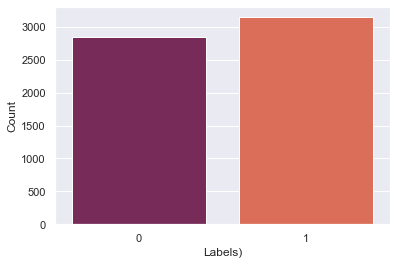

In [57]:
sns.set_theme(style="darkgrid")
sns.countplot(x="label", data=df_train, palette="rocket")
plt.xlabel('Labels)')
plt.ylabel('Count')
plt.show()

In [58]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [59]:
class TrainingDataset(Dataset):
    def __init__(self, df):
        self.dataframe = df
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, index):
        tokenization_values = roberta_tokenizer.encode_plus(
                    self.dataframe.loc[index, 'premise'],  self.dataframe.loc[index, 'hypothesis'],  
                    max_length = 128,   
                    truncation=True,
                    return_attention_mask = True,  
                    pad_to_max_length = True, 
                    return_tensors = 'pt',         
               )  
        return (tokenization_values['input_ids'][0], tokenization_values['attention_mask'][0], torch.tensor(self.dataframe.loc[index, 'label']))

In [60]:
cuda_cpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base',num_labels = 2)
roberta_model.to(cuda_cpu)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [61]:
adam_optimizer = AdamW(roberta_model.parameters(),lr = 2e-5, eps = 1e-8)

In [62]:
training_dataset = TrainingDataset(df_train)
train_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32,shuffle=True, num_workers=os.cpu_count())
development_dataset = TrainingDataset(df_dev)
val_dataloader = torch.utils.data.DataLoader(development_dataset,batch_size=32,shuffle=True, num_workers=os.cpu_count())

In [63]:
for epoch in range(0, 4): 
    print(' Number of Epoch {:} / {:}'.format(epoch + 1, 4))
    

    list_of_targets,list_of_targets_value = [], [] 

    training_loss_roberta = 0
    roberta_model.train()
    torch.set_grad_enabled(True)
    for i, (input_ids, input_mask, labels) in enumerate(train_dataloader):
        roberta_model.zero_grad()        
        training_result = roberta_model(input_ids.to(cuda_cpu), 
                    attention_mask=input_mask.to(cuda_cpu),
                    labels=labels.to(cuda_cpu))
        loss = training_result[0]
        training_loss_roberta = training_loss_roberta + loss.item()
        training_predictions = training_result[1].detach().cpu().numpy()
        targets_np = labels.to('cpu').numpy()
        list_of_targets.extend(targets_np)
        if i == 0:  
            vstack_training_predictions = training_predictions
        else:
            vstack_training_predictions = np.vstack((vstack_training_predictions, training_predictions))
        adam_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)
        adam_optimizer.step() 
    y_true_train = list_of_targets
    y_pred_train = np.argmax(vstack_training_predictions, axis=1)
    train_acc = accuracy_score(y_true_train, y_pred_train)


    print('Training Loss ===>' ,training_loss_roberta)
    print("Training Accuracy ===>",train_acc)
    print('\n')
    print("Validation Section Starts Here")



    roberta_model.eval()
    torch.set_grad_enabled(False)
    validation_loss = 0
    
    
    for j, (input_ids, input_mask, labels) in enumerate(tqdm(val_dataloader)):
        b_input_ids = input_ids.to(cuda_cpu)
        b_input_mask = input_mask.to(cuda_cpu)
        b_labels = labels.to(cuda_cpu)      
        validation_result = roberta_model(b_input_ids, 
                attention_mask=b_input_mask, 
                labels=b_labels)
        
        loss = validation_result[0]
        validation_loss = validation_loss + loss.item()
        preds = validation_result[1]

        #prediction_values = preds.detach().cpu().numpy()

        #targets_np = b_labels.to('cpu').numpy()
        list_of_targets_value.extend(b_labels.to('cpu').numpy())

        if j == 0:  
            #vstack_validation_predictions = prediction_values
            vstack_validation_predictions = preds.detach().cpu().numpy()


        else:
            #vstack_validation_predictions = np.vstack((vstack_validation_predictions, prediction_values))
            vstack_validation_predictions = np.vstack((vstack_validation_predictions, preds.detach().cpu().numpy()))


    true_validation_accuracy = list_of_targets_value

    prediction_validation_accuracy = np.argmax(vstack_validation_predictions, axis=1)
    validation_accuracy = accuracy_score(true_validation_accuracy, prediction_validation_accuracy)

    print('Validation Loss ===> ' ,validation_loss)
    print('Validation Accuracy ===>  ', validation_accuracy)

    gc.collect()


 Number of Epoch 1 / 4
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ayushtripathi/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ayushtripathi/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'TrainingDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

### Output Prediction Result File

You will need to submit a prediction result file. It should have 2028 lines, every line should be either 0 or 1, which is your model's prediction on the respective test set instance.

In [ ]:
# suppose you had your model's predictions on the 2028 test cases read from test_enc_unlabeled.tsv, and 
#those results are in the list called 'results'
assert (len(results) == 4850)

In [ ]:
# make sure the results are not float numbers, but intergers 0 and 1
results = [int(x) for x in results]

In [ ]:
# write your prediction results to 'upload_predictions.txt' and upload that later
with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
    for x in results:
        fp.write(str(x) + '\n')